In [38]:
from pandas import read_csv

def read_data(file_path, num_features = 2):
    series_influ_A_df = read_csv(file_path, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})

    # because since 2011-03-01 It was announced that the H1N12009 flu had been controlled and treated as regular seasonal flu and
    # since 2020-02-01, it's time for covid 
    
    series_influ_A_df = series_influ_A_df.loc [(series_influ_A_df['Month'] >='2011-04-01') & (series_influ_A_df['Month'] <='2020-02-01')]
    return series_influ_A_df.dropna()[["case", "temp", "dew", "tempmax", "humidity","tempmin","windspeed"][:num_features]]

file_path = '../../temp_data/influA_vietnam_temp_month.csv'
#Load data set
df = read_data(file_path)

In [39]:
df.corr()

,case,temp
case,1.000000,0.478571
temp,0.478571,1.000000


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

def calculate_errors(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Root Mean Squared Percentage Error (RMSPE)
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100
    
    # Mean Absolute Residual (MARE)
    mare = np.mean(np.abs(y_true - y_pred))
    
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    # Normalized Nash-Sutcliffe Efficiency (NNSE)
    nnse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((np.abs(y_true - np.mean(y_true)) + np.abs(y_pred - np.mean(y_true))) ** 2))
    
    return mae, mse, rmse, mape, rmspe, mare, nse, nnse

In [69]:
import numpy as np
from sklearn.metrics import r2_score

# def create_dataset(dataset, look_back=2, num_predict=1):
#     dataX, dataY = [], []
#     for i in range(0, len(dataset)-2 *look_back+1, look_back - num_predict):
#         a = dataset[i:(i+look_back)]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back - num_predict : i+ 2*look_back-num_predict])
#     return np.array(dataX), np.array(dataY)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def forecast(input, model):
    input = input.reshape(1, input.shape[0], input.shape[1])
    predicted = model.predict(input, verbose=0)
    return predicted[0]

def make_forecasts(test, model):
    forecasts = []
    inputStart = test[0]
    inputX = inputStart.reshape(1, inputStart.shape[0], inputStart.shape[1])
    for i in range(len(test)):
        predicted = forecast(inputX[i], model)
        forecasts.append(predicted)
        inputXContinue = np.vstack((inputX[-1][1:], predicted))
        inputX = np.append(inputX, [inputXContinue], axis=0)
    
    return forecasts
def evaluate_forecasts(test, forecasts):
    from sklearn.metrics import mean_squared_error
    testScore = np.sqrt(mean_squared_error(test, forecasts))
    print('Test Score: %.2f RMSE' % (testScore))
    return testScore

def plot_r2(x,y, file_path=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats

    # Generate some sample data
    # x = y_inverse.flatten()
    # y = y_hat_inverse.flatten()

    # Compute the linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Create the R-squared line
    r2_line = slope * x + intercept
    r2 = r2_score(x, y)
    r2_pearson = r_value**2
    squared_error = np.square(x-y)

    # Print error metrics
    mae, mse, rmse, mape, rmspe, mare, nse, nnse = calculate_errors(x, y)
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'RMSPE: {rmspe:.2f}%')
    print(f'MARE: {mare:.2f}')
    print(f'NSE: {nse:.2f}')
    print(f'NNSE: {nnse:.2f}')

    # Create the scatter plot
    plt.figure(figsize=(10, 12))

    # Subplot 1: Scatter plot and regression line
    plt.subplot(3, 1, 1)
    plt.scatter(x, y, label='Data Points')
    plt.plot(x, r2_line, color='red', marker="o", label=f'Regression line')
    plt.title('Correlation ')

    # Add labels and title
    plt.xlabel('actual number of infection')
    plt.ylabel('forecast number of infection')
    plt.title(f'Scatter Plot with R-squared Line\nCorrelation: {r_value:.2f}, R^2: {r2_pearson:.2f}')
    plt.legend()
    plt.grid()

    # Subplot 2: Real values over time
    plt.subplot(3, 1, 2)
    plt.plot( x, color='blue', label='Real_values')
    plt.xlabel('Time')
    plt.ylabel('Real_values')
    plt.title('Real Values over Time')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Forecast values over time
    plt.subplot(3, 1, 3)
    plt.plot(y, color='green', label='Forecast_values')
    plt.xlabel('Time')
    plt.ylabel('Forecast_values')
    plt.title('Forecast Values over Time')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    # plt.savefig(file_path)
    # plt.close()
    plt.show()

def save_plot(x,y, file_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats

    # Generate some sample data
    # x = y_inverse.flatten()
    # y = y_hat_inverse.flatten()

    # Compute the linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Create the R-squared line
    r2_line = slope * x + intercept
    r2 = r2_score(x, y)
    r2_pearson = r_value**2
    squared_error = np.square(x-y)

    # Print error metrics
    mae, mse, rmse, mape, rmspe, mare, nse, nnse = calculate_errors(x, y)

    # Create the scatter plot
    plt.figure(figsize=(10, 12))

    # Subplot 1: Scatter plot and regression line
    plt.subplot(3, 1, 1)
    plt.scatter(x, y, label='Data Points')
    plt.plot(x, r2_line, color='red', marker="o", label=f'Regression line')
    plt.title('Correlation ')

    # Add labels and title
    plt.xlabel('actual number of infection')
    plt.ylabel('forecast number of infection')
    plt.title(f'Scatter Plot with R-squared Line\nCorrelation: {r_value:.2f}, R^2: {r2_pearson:.2f}')
    plt.legend()
    plt.grid()

    # Subplot 2: Real values over time
    plt.subplot(3, 1, 2)
    plt.plot( x, color='blue', label='Real_values')
    plt.xlabel('Time')
    plt.ylabel('Real_values')
    plt.title('Real Values over Time')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Forecast values over time
    plt.subplot(3, 1, 3)
    plt.plot(y, color='green', label='Forecast_values')
    plt.xlabel('Time')
    plt.ylabel('Forecast_values')
    plt.title('Forecast Values over Time')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    return mae, mse, rmse, mape, rmspe, mare, nse, nnse, r2_pearson, r_value

def plot(testY, forecasts):
    import matplotlib.pyplot as plt
    forecastsPlot = np.empty([forecasts.shape[0]])
    forecastsPlot[:] = np.nan
    forecastsPlot[:] = forecasts[:,0].reshape(-1)
    testPlot = np.empty([testY.shape[0]])
    testPlot[:] = np.nan
    testPlot[:] = testY[:,0].reshape(-1)
    plt.plot(testPlot, "-y", label="actual", marker= '.')
    plt.plot(forecastsPlot, color = 'green', label="forecast", marker='x')
    plt.ylabel("Number of infections")
    plt.legend(["actual", "forecast"])
    plt.show()
def save(testY, forecasts, file_path):
    import matplotlib.pyplot as plt
    forecastsPlot = np.empty([forecasts.shape[0]])
    forecastsPlot[:] = np.nan
    forecastsPlot[:] = forecasts[:,0].reshape(-1)
    testPlot = np.empty([testY.shape[0]])
    testPlot[:] = np.nan
    testPlot[:] = testY[:,0].reshape(-1)
    plt.plot(testPlot, "-y", label="actual", marker= '.')
    plt.plot(forecastsPlot, color = 'green', label="forecast", marker='x')
    plt.ylabel("Number of infections")
    plt.legend(["actual", "forecast"])
    plt.savefig(file_path)
    plt.close()
    
def plot_month_per_year(df, key):
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Month'], y=df[key], mode='lines+markers', name=f'Influenza A Cases in month'))
    fig.update_layout(
        title='Influenza A Cases Over Time',
        xaxis=dict(
            title='Month',
            tickvals=df['Month'],  
            tickformat='%Y-%m',
            tickangle=90,
        ),
        yaxis=dict(title='Number of Cases'),
        showlegend=True,
    )
 
    # Show plot
    fig.show()

In [41]:
# Preprocessing
def find_outliers_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    return outliers

outliers = find_outliers_IQR(df['case'])

print('number of outliers: '+ str(len(outliers)))

print('max outlier value: '+ str(outliers.max()))

print('min outlier value: '+ str(outliers.min()))

number of outliers: 4
max outlier value: 158.0
min outlier value: 120.0


## Plot data with some imputation methods

In [42]:
def remove_outlier_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    upper = df[~(df>(q3+1.5*IQR))].max()

    lower = df[~(df<(q1-1.5*IQR))].min()

    df = np.where(
        df > upper,
        np.nan,
        np.where(df < lower,np.nan,df)
        )
    return df
impute_df = df.copy()
impute_df['case'] = remove_outlier_IQR(df['case'])
# plot_month_per_year(impute_df, 'case')

In [43]:
linear_df = impute_df.copy()
linear_df['case'] = linear_df['case'].interpolate(method='linear')
# plot_month_per_year(linear_df, 'case')

In [44]:
spline_order_df = impute_df.copy()
spline_order_df['case'] = spline_order_df['case'].interpolate(method='spline', order=3)
# plot_month_per_year(spline_order_df, 'case')

In [45]:
def remove_outlier_impute(df, impute_method= 'linear'):
    output_df = df.copy()
    output_df["case"] = remove_outlier_IQR(df['case'])
    match impute_method:
        case 'linear':
            output_df['case'] = output_df['case'].interpolate(method='linear')
        case 'spline':
            output_df['case'] = output_df['case'].interpolate(method='spline', order=3)
        case _:
            pass
    return output_df

## Prepare data

In [46]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

def prepare_data(df, is_ma=False, scaler =None):
    import pandas as pd
    # df_ = pd.DataFrame()
    # df_ = df[["case", "temp"]]
    df_ = df.copy()
    if is_ma:
        # Apply Moving Average Filter
        window_size = 2
        
        df_['case'] = exponential_moving_average(df_['case'], window_size)
        df_ = df_.dropna()
    dataset = df_.values
    if scaler:
        flattened_dataset = dataset.flatten()
        dataset_trans = scaler.fit_transform(flattened_dataset.reshape(-1,1))
        dataset = dataset_trans.reshape(dataset.shape)
    return  dataset

scaler = MinMaxScaler()
dataset = prepare_data(df = linear_df, scaler=scaler, is_ma=True)

In [47]:

#process data
num_predict = 5
look_back = 8
test_size = num_predict * 2
train = dataset[: -test_size,:]
test = dataset[-test_size - look_back:,:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

## Custom loss

In [48]:
# i = 86
# print(trainX[i], trainY[i])
# len(trainX)
# j=0
# print(testX[j], testY[j])
import tensorflow as tf
from keras.losses import mean_squared_error, huber
def custom_loss(y_true, y_pred):
    return tf.sqrt(mean_squared_error(y_true, y_pred)/2)

# def custom_loss(y_true, y_pred):
#     """
#     Custom loss function that penalizes high losses.
#     """
#     # Calculate the standard loss
#     standard_loss = mean_squared_error(y_true ,y_pred)

#     # Apply a penalty function to the loss
#     penalty_factor = 3.0  # Adjust this value to control the penalty strength
#     penalty = tf.maximum(standard_loss - 0.05, 0.0) * penalty_factor

#     # Combine the standard loss and the penalty
#     total_loss = tf.sqrt(standard_loss) + penalty

#     return total_loss
def trend_loss(y_true, y_pred):
    """
    Custom loss function that focuses on capturing the trend of the time series.
    """
    true_trend = tf.math.subtract(y_true[:, 1:], y_true[:, :-1])
    pred_trend = tf.math.subtract(y_pred[:, 1:], y_pred[:, :-1])

    # Calculate the mean squared error of the trends
    trend_mse = tf.sqrt(mean_squared_error(true_trend, pred_trend))

    return trend_mse

def custom_loss_hubber_loss(y_true, y_pred):
    print(y_true.shape)
    hubber_loss = huber(y_true, y_pred, 0.1)
    trend_weight = 0
    trend_loss_value = trend_loss(y_true, y_pred)
    return (1 - trend_weight) *hubber_loss + trend_weight * trend_loss_value


In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, TimeDistributed, Input, Dropout, GRU,concatenate, Bidirectional
from sklearn.model_selection import GridSearchCV
from keras.saving import register_keras_serializable
from sklearn.metrics import r2_score


# hybrid model

# def build_model(input_shape, dropout=None, dense_units = [], unit=64, optimizer='adam'):
#     input = Input(shape=input_shape)
#     # LSTM Model
#     lstm_model = Sequential([
#         LSTM(unit, activation='relu'),
#     ])

#     # GRU Model
#     gru_model = Sequential([
#         # Input(input_shape=input_shape),
#         GRU(unit, activation='relu'),
#     ])

#     gru_model1 = Sequential([
#         # Input(input_shape=input_shape),
#         GRU(unit, activation='relu'),
#     ])

#     # GRU Model
#     rnn_model = Sequential([
#         # Input(input_shape=input_shape),
#         SimpleRNN(unit, activation='relu'),
#     ])

#     gru_output = gru_model(input)
#     gru_output1 = gru_model1(input)
#     # lstm_output = lstm_model(input)
#     rnn_output = rnn_model(input)
#     # gru_output1 = gru_model1(input)

#     combined_output = concatenate([ rnn_output, gru_output, gru_output1])

#     dense_layers = Sequential([
#     Dense(units=input_shape[1], activation='sigmoid' )
#     ])

#     final_output = dense_layers(combined_output)
#     model = tf.keras.Model(inputs=input, outputs=final_output)
#     model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=0.1), metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

#loss=tf.keras.losses.Huber(delta=0.1)

def build_model(input_shape, use_layer= "RNN", dropout=None, unit=64, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # model.add(GRU(units=unit, activation='relu', return_sequences=True))
    match use_layer:
        case "GRU":
            model.add(GRU(units=unit, activation='relu'))
        case "LSTM":
            model.add(LSTM(units = unit, activation='relu'))
        case _:
            model.add(SimpleRNN(units=unit, activation='relu'))

    # model.add(LSTM(units=unit, activation='relu'))
    model.add(Dense(units=input_shape[1], activation='sigmoid' ))
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=0.15), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


In [50]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
# model = build_model(input_shape=(trainX.shape[1], trainX.shape[2]), unit=32)
# es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
# file_path = os.path.join('../model', 'test.keras')

# mc = ModelCheckpoint(file_path, monitor='loss', mode='min', verbose=1, save_best_only=True)

# model.fit(trainX, trainY,batch_size=1, callbacks=[es, mc], verbose=0, epochs=200)


Epoch 1: loss improved from inf to 0.02412, saving model to ../model\test.keras

Epoch 2: loss improved from 0.02412 to 0.00931, saving model to ../model\test.keras

Epoch 3: loss improved from 0.00931 to 0.00866, saving model to ../model\test.keras

Epoch 4: loss improved from 0.00866 to 0.00767, saving model to ../model\test.keras

Epoch 5: loss improved from 0.00767 to 0.00755, saving model to ../model\test.keras

Epoch 6: loss improved from 0.00755 to 0.00731, saving model to ../model\test.keras

Epoch 7: loss improved from 0.00731 to 0.00695, saving model to ../model\test.keras

Epoch 8: loss improved from 0.00695 to 0.00670, saving model to ../model\test.keras

Epoch 9: loss improved from 0.00670 to 0.00654, saving model to ../model\test.keras

Epoch 10: loss improved from 0.00654 to 0.00634, saving model to ../model\test.keras

Epoch 11: loss improved from 0.00634 to 0.00607, saving model to ../model\test.keras

Epoch 12: loss improved from 0.00607 to 0.00581, saving model to .

In [51]:
from keras.models import load_model
import os
file_path = os.path.join('../model', 'test.keras')
model = load_model(file_path, custom_objects={"custom_loss": custom_loss})


forecasts = make_forecasts(testX, model)
# invert predictions
forecasts = scaler.inverse_transform(forecasts)
testY_ = scaler.inverse_transform(testY)

Test Score: 6.88 RMSE


6.880109358105918

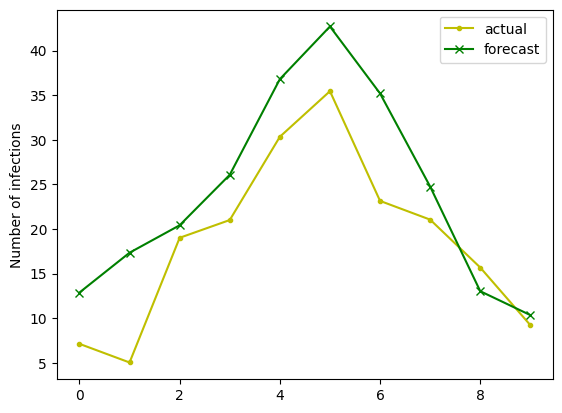

In [52]:
# plot(testY_, forecasts) 

MAE: 5.78
MSE: 47.34
RMSE: 6.88
MAPE: 49.65%
RMSPE: 84.22%
MARE: 5.78
NSE: 0.45
NNSE: 0.88


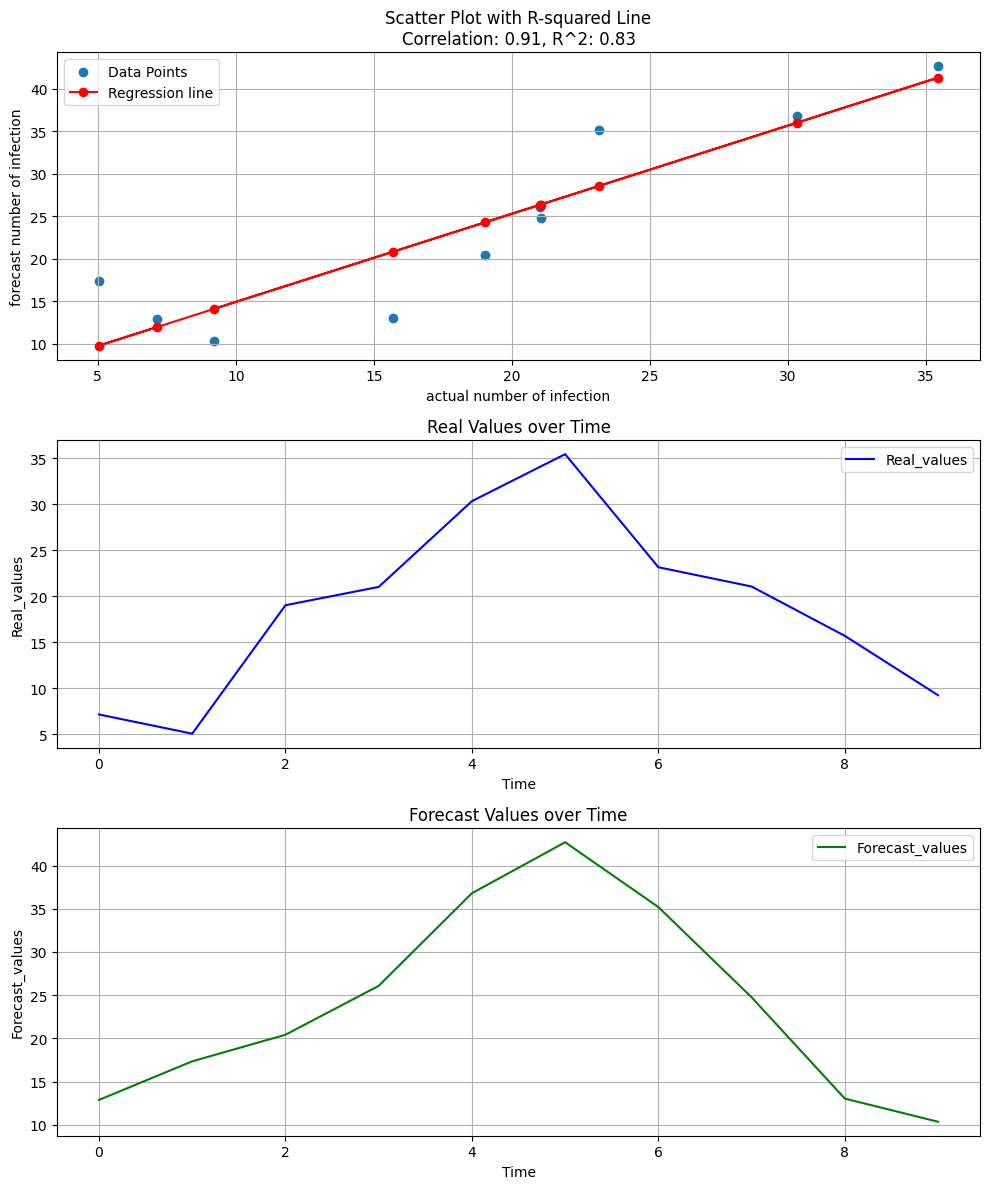

In [70]:
# plot_r2(testY_[:,0].flatten(), forecasts[:,0].flatten())

In [54]:
# r2 = r2_score(testY_.flatten(), forecasts.flatten())
# r2

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


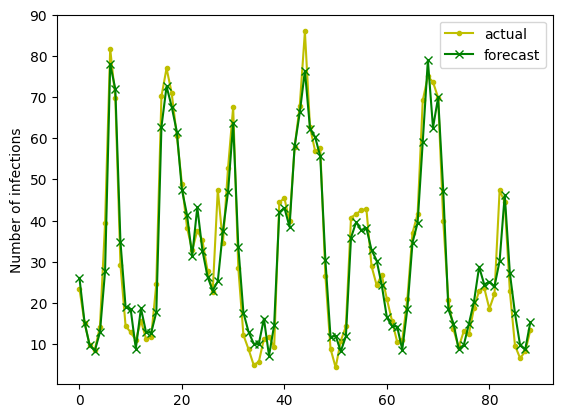

In [76]:
# trainY_hat = model.predict(trainX)
# trainY_hat_inverse = scaler.inverse_transform(trainY_hat)
# trainY_inverse = scaler.inverse_transform(trainY)
# plot(trainY_inverse, trainY_hat_inverse)

## Tuning hyper parameter

In [56]:
import itertools
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os, json
from keras.models import load_model

def Month_HyperParameter_Tuning(config, scaler):
    impute_methods, look_backs, num_features, n_neurons, use_layers, is_mas = config
    possible_combinations = list(itertools.product(impute_methods, look_backs, num_features, n_neurons, use_layers, is_mas))
    print(possible_combinations)
    print('\n')

    hist = []
    for i in range(0, len(possible_combinations)):
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        impute_method, look_back, num_feature, n_neuron, use_layer, is_ma = possible_combinations[i]
        file_path = '../../temp_data/influA_vietnam_temp_month.csv'
        #Load data set
        df = read_data(file_path, num_features=num_feature)
        output_df = remove_outlier_impute(df, impute_method)

        dataset = prepare_data(df = output_df, scaler=scaler, is_ma=is_ma)

        num_predict = 5
        # look_back = 8
        test_size = num_predict * 2
        train = dataset[: -test_size,:]
        test = dataset[-test_size - look_back:,:]

        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)
        model = build_model(
            input_shape=(trainX.shape[1], trainX.shape[2]),
            use_layer=use_layer,
            unit=n_neuron
            )
        es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
        result_dir = os.path.join("../../result", f"""month_min_max_m2m""", "RNN_LSTM_GRU")
        result_combination_dir = os.path.join(result_dir, str(i))
        os.makedirs(result_combination_dir, exist_ok=True)
        file_path = os.path.join(result_combination_dir, 'best_month_model.keras')
        mc = ModelCheckpoint(file_path, monitor='loss', mode='min', verbose=1, save_best_only=True)
        model.fit(trainX, trainY, batch_size=1, callbacks=[es, mc], verbose=0, epochs=200) 
        config = {
            "num_feature": num_feature,
            "use_layer": use_layer,
            "unit": n_neuron,
            "look_back": look_back,
            "is_ma": is_ma,
            "impute_method": impute_method,
        } 
        with open(os.path.join(result_combination_dir,'config.json'), 'w') as f:
            json.dump(config, f)

    for i in range(0, len(possible_combinations)):
        impute_method, look_back, num_feature, n_neuron, use_layer, is_ma = possible_combinations[i]

        file_path = '../../temp_data/influA_vietnam_temp_month.csv'
        #Load data set
        df = read_data(file_path, num_features=num_feature)
        output_df = remove_outlier_impute(df, impute_method)

        dataset = prepare_data(df = output_df, scaler=scaler, is_ma=is_ma)

        num_predict = 5
        # look_back = 8
        test_size = num_predict * 2
        train = dataset[: -test_size,:]
        test = dataset[-test_size - look_back:,:]

        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)


        result_dir = os.path.join("../../result", f"""month_min_max_m2m""", "RNN_LSTM_GRU")
        result_combination_dir = os.path.join(result_dir, str(i))
        os.makedirs(result_combination_dir, exist_ok=True)
        file_path = os.path.join(result_combination_dir, 'best_month_model.keras')

        model = load_model(file_path)

        forecasts = make_forecasts(testX, model)
        # invert predictions
        forecasts = scaler.inverse_transform(forecasts)
        testY_ = scaler.inverse_transform(testY)
        # evaluate_forecasts(testY_[:,0].reshape(-1), forecasts[:, 0].reshape(-1))
        
        r2_image_path = os.path.join(result_combination_dir, 'r2_image.png')
        mae, mse, rmse, mape, rmspe, mare, nse, nnse, r2_pearson, r_value = save_plot(testY_[:,0].flatten(), forecasts[:,0].flatten(), r2_image_path)
        hist.append(list((impute_method, look_back, num_feature, n_neuron, use_layer, is_ma, rmse, r2_pearson,r_value, mae, mse, mape, rmspe, mare, nse, nnse)))
        test_image_path = os.path.join(result_combination_dir, 'test.png')
        train_image_path = os.path.join(result_combination_dir, 'train.png')
        save(testY_, forecasts, test_image_path)

        trainY_hat = model.predict(trainX)
        trainY_hat_inverse = scaler.inverse_transform(trainY_hat)
        trainY_inverse = scaler.inverse_transform(trainY)
        save(trainY_inverse, trainY_hat_inverse, train_image_path)
    import pandas as pd
    hist_df = pd.DataFrame(hist)
    hist_df = hist_df.rename(columns={
        0: 'impute_method', 
        1: 'look_back', 
        2: 'num_feature', 
        3: 'unit', 
        4: 'use_layer', 
        5: 'is_ma', 
        6:'rmse', 
        7: 'r2_score', 
        8: 'correlation', 
        9:'mae', 
        10: 'mse', 
        11:'mape', 
        12:'rmspe', 
        13:'mare', 
        14:'nse', 
        15:'nnse'
        })
    hist_df = hist_df.sort_values(by=['r2_score'], ascending=False)
    hist_df.to_csv(os.path.join(result_dir, 'history.csv'))
    return hist_df
        

In [57]:
num_features = [2,3]
use_layers = ["GRU", "LSTM", "RNN"]
units = [64]
look_backs = [8,10]
is_mas = [True, False]
impute_methods = ["linear", "spline"]

config = [impute_methods, look_backs, num_features, units, use_layers, is_mas]
# hist = Month_HyperParameter_Tuning(config, scaler)